# Sentiment Analysis with Deep Learning

This notebook develops a sentiment classification system on the Twitter dataset.
We focus on deep learning models (BiLSTM, CNN, Dense with TF-IDF) and compare results.
The notebook also includes exploratory data analysis (EDA), preprocessing, training, evaluation, and experiments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Paths (update if necessary)
TRAIN_PATH = '../Datasets/twitter_training.csv'
VAL_PATH = '../Datasets/twitter_validation.csv'

# Load data (no headers in CSV)
cols = ["id", "entity", "sentiment", "text"]
train_df = pd.read_csv(TRAIN_PATH, header=None, names=cols)
val_df = pd.read_csv(VAL_PATH, header=None, names=cols)

train_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TestSolutions\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Exploratory Data Analysis (EDA)
We first inspect class distribution, text lengths, and most frequent words to understand the dataset.

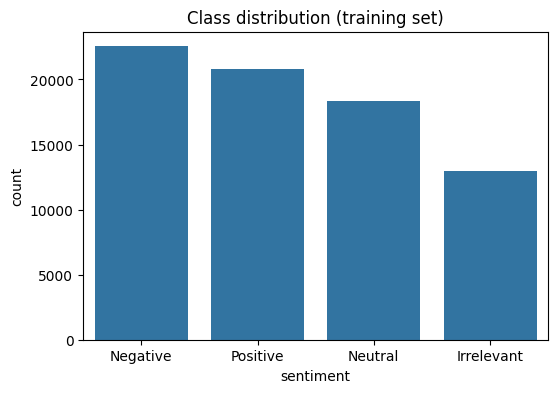

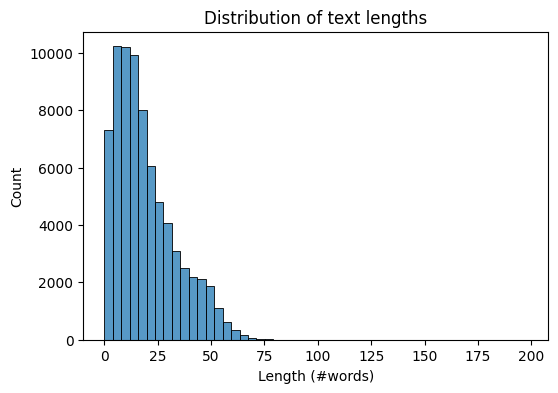

,word,count
0,the,44099
1,i,28916
2,to,28652
3,and,26322
4,a,23925
5,of,19307
6,is,17453
7,for,15410
8,in,15046
9,/,14655


In [2]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=train_df, order=train_df['sentiment'].value_counts().index)
plt.title("Class distribution (training set)")
plt.show()

# Handle missing text values
train_df["text"] = train_df["text"].fillna("")

# Text length distribution
train_df["text_len"] = train_df["text"].astype(str).str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(train_df["text_len"], bins=50, kde=False)
plt.title("Distribution of text lengths")
plt.xlabel("Length (#words)")
plt.show()

# Most frequent words (basic token split)
from collections import Counter
all_words = " ".join(train_df["text"].astype(str)).lower().split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)
pd.DataFrame(common_words, columns=["word","count"])


## Preprocessing
Steps: lowercase, remove non-alphabetic chars, remove stopwords, tokenize, pad sequences.
We also prepare TF-IDF features for comparison.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

train_df["clean_text"] = train_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df["sentiment"])
y_val = le.transform(val_df["sentiment"])

# TF-IDF features
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(train_df["clean_text"]).toarray()
X_val_tfidf = tfidf.transform(val_df["clean_text"]).toarray()

# Tokenizer for sequences
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df["clean_text"])
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df["clean_text"]), maxlen=MAX_SEQ_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df["clean_text"]), maxlen=MAX_SEQ_LEN)
word_index = tokenizer.word_index

print("Train sequences:", X_train_seq.shape, "Val sequences:", X_val_seq.shape)
print("TF-IDF:", X_train_tfidf.shape)

Train sequences: (74682, 100) Val sequences: (1000, 100)
TF-IDF: (74682, 10000)


## Deep Learning Models
We compare three models:
- **BiLSTM** with embeddings
- **CNN** with embeddings
- **Dense NN** with TF-IDF inputs

In [4]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(np.unique(y_train))
if num_classes == 2:
    y_train_keras = y_train
    y_val_keras = y_val
    multiclass = False
else:
    y_train_keras = to_categorical(y_train, num_classes=num_classes)
    y_val_keras = to_categorical(y_val, num_classes=num_classes)
    multiclass = True

# Compute class weights
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i:w for i,w in enumerate(weights)}
class_weights

{0: np.float64(1.4372979214780601),
 1: np.float64(0.8282539260047911),
 2: np.float64(1.0192433671798231),
 3: np.float64(0.8962413594470046)}

In [5]:
EMBED_DIM = 100

def build_lstm_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, input_length=MAX_SEQ_LEN),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model

def build_cnn_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, input_length=MAX_SEQ_LEN),
        Conv1D(128, 5, activation="relu"),
        MaxPooling1D(5),
        Conv1D(128, 5, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model

def build_dense_tfidf(input_dim):
    model = Sequential([
        Dense(512, activation="relu", input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

# Create a directory for saving plots
os.makedirs("plots", exist_ok=True)

experiment_grid = [
    {"model_type":"lstm","lr":1e-3,"batch_size":64,"optimizer":"adam","epochs":5},
    {"model_type":"cnn","lr":1e-3,"batch_size":64,"optimizer":"rmsprop","epochs":5},
    {"model_type":"tfidf_dense","lr":1e-3,"batch_size":64,"optimizer":"adam","epochs":5}
]

def create_dataset(X, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

results = []
vocab_size = min(MAX_NUM_WORDS, len(word_index)+1)

for cfg in experiment_grid:
    print("\nRunning", cfg)
    if cfg["model_type"]=="lstm":
        model = build_lstm_model(vocab_size)
        x_train, x_val = X_train_seq, X_val_seq
    elif cfg["model_type"]=="cnn":
        model = build_cnn_model(vocab_size)
        x_train, x_val = X_train_seq, X_val_seq
    else:
        model = build_dense_tfidf(X_train_tfidf.shape[1])
        x_train, x_val = X_train_tfidf, X_val_tfidf

    opt = Adam(learning_rate=cfg["lr"]) if cfg["optimizer"]=="adam" else RMSprop(learning_rate=cfg["lr"])
    loss = "categorical_crossentropy" if multiclass else "binary_crossentropy"
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    if cfg["model_type"] == "tfidf_dense":
        train_ds = create_dataset(x_train, y_train_keras, cfg["batch_size"])
        val_ds = create_dataset(x_val, y_val_keras, cfg["batch_size"])
        history = model.fit(train_ds, validation_data=val_ds,
                            epochs=cfg["epochs"], class_weight=class_weights, verbose=1)
    else:
        history = model.fit(x_train, y_train_keras,
                            validation_data=(x_val, y_val_keras),
                            epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                            class_weight=class_weights, verbose=1)

    preds_proba = model.predict(x_val)
    preds = np.argmax(preds_proba, axis=1) if multiclass else (preds_proba.squeeze()>0.5).astype(int)

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="weighted" if multiclass else "binary")
    cm = confusion_matrix(y_val, preds)
    print("Acc:", acc, "F1:", f1)

    # Save confusion matrix as image
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {cfg['model_type'].upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"plots/cm_{cfg['model_type']}.png", bbox_inches="tight", dpi=300)
    plt.close()

    results.append({**cfg, "acc": acc, "f1": f1, "cm": cm.tolist()})

# Create and save results table
results_df = pd.DataFrame(results)

# Save as CSV
results_df.to_csv("plots/results_table.csv", index=False)

# Save as image
fig, ax = plt.subplots(figsize=(10, 2 + len(results) * 0.5))
ax.axis("off")
table = ax.table(cellText=results_df.drop(columns=["cm"]).values,  # Exclude cm for table
                 colLabels=results_df.drop(columns=["cm"]).columns,
                 cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.savefig("plots/results_table.png", bbox_inches="tight", dpi=300)
plt.close()


Running {'model_type': 'lstm', 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 5}
Epoch 1/5


c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.6524 - loss: 0.8780 - val_accuracy: 0.8980 - val_loss: 0.3215
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 71s 61ms/step - accuracy: 0.8457 - loss: 0.4182 - val_accuracy: 0.9290 - val_loss: 0.2308
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.8861 - loss: 0.3047 - val_accuracy: 0.9400 - val_loss: 0.2056
Epoch 4/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.9021 - loss: 0.2571 - val_accuracy: 0.9430 - val_loss: 0.2372
Epoch 5/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 71s 61ms/step - accuracy: 0.9140 - loss: 0.2261 - val_accuracy: 0.9470 - val_loss: 0.2163
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Acc: 0.947 F1: 0.9469885039145334

Running {'model_type': 'cnn', 'lr': 0.001, 'batch_size': 64, 'optimizer': 'rmsprop', 'epochs': 5}
Epoch 1/5


c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.5442 - loss: 1.0721 - val_accuracy: 0.8120 - val_loss: 0.5715
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7837 - loss: 0.5900 - val_accuracy: 0.9130 - val_loss: 0.2784
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8631 - loss: 0.3640 - val_accuracy: 0.9250 - val_loss: 0.2614
Epoch 4/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8940 - loss: 0.2748 - val_accuracy: 0.9280 - val_loss: 0.2890
Epoch 5/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.9067 - loss: 0.2362 - val_accuracy: 0.9320 - val_loss: 0.3108
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Acc: 0.932 F1: 0.9321992509086995

Running {'model_type': 'tfidf_dense', 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 5}


c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.4761 - loss: 1.1945 - val_accuracy: 0.6570 - val_loss: 0.8531
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.6917 - loss: 0.7847 - val_accuracy: 0.8470 - val_loss: 0.4557
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.8316 - loss: 0.4514 - val_accuracy: 0.9060 - val_loss: 0.2746
Epoch 4/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.8986 - loss: 0.2725 - val_accuracy: 0.9470 - val_loss: 0.1871
Epoch 5/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9251 - loss: 0.1952 - val_accuracy: 0.9630 - val_loss: 0.1472
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Acc: 0.963 F1: 0.9629889108507764


## Evaluation
We report accuracy, F1-score, and confusion matrices for each model. Results are stored in the experiment table above.